# Energy System Modelling - Tutorial V.2

**Classic screening curve analysis for generation investment**

Let us suppose that demand is inelastic. The demand-duration curve is given by $D=1000-1000z$. Suppose that there is a choice between coal and gas generation plants with a variable cost of 2 and 12 €/MWh, together with load-shedding at 1012 €/MWh. The fixed costs of coal and gas generation are 15 and 10 €/MWh, respectively.

**Imports**

In [5]:
import pypsa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline

**Read Data**

In [6]:
#Generator marginal (m) and capital (c) costs in EUR/MWh
generators = {"coal" : {"m" : 2, "c" : 15},
              "gas" : {"m" : 12, "c": 10},
              "load-shedding" : {"m" : 1012, "c" : 0}}

***
**(a) Describe the concept of a screening curve and how it helps to determine generation investment, given a demand-duration curve.**

A screening curve plots the costs of different generators as a
function of their utilization / capacity / usage factor so that they can
be compared based on their fixed and variable costs. The utilization
factor is plotted along the $x$ axis from 0 to 1, 0 corresponding to
no running time, 1 corresponding to the power plant running 100 % of
the time. The intercept of the curve of each generator with the $y$
axis is given by the fixed cost $f$ €/MWh (i.e. the cost with no
variable costs) and the slope is given by the variable cost $c$
€/MWh.

The interception points of the linear curves of the different
generators determine the ranges of utilization factors in which one
generator is cheaper than another. By comparing the screening curves with the demand duration curve, the
correct generator capacities for different utilisation factors can be
determined (e.g. how much baseload power is required, how much peaking
power is required, how much load shedding).

***
**(b) Plot the screening curve and find the intersections of the generation technologies.**

Text(0.5, 0, 'full load hours [per unit]')

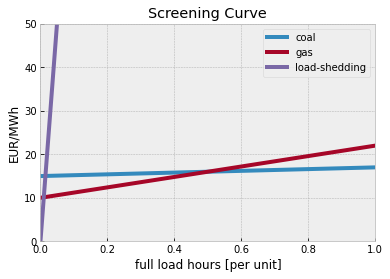

In [7]:
x = np.linspace(0,1,101)
df = pd.DataFrame(
        {key : pd.Series(item["c"] + x*item["m"],x) for key,item in generators.items()}
     )
df.plot(ylim=[0,50],xlim=[0,1], title="Screening Curve", linewidth=4)
plt.ylabel("EUR/MWh")
plt.xlabel("full load hours [per unit]")

Screening curve intersections at 0.01 and 0.5

***
**(c) Compute the long-term equilibrium power plant investment (optimal mix of generation).**

Build the PyPSA network:

In [8]:
n = pypsa.Network()

num_snapshots = 1001

snapshots = np.linspace(0,1,num_snapshots)

n.set_snapshots(snapshots)

n.snapshot_weightings = n.snapshot_weightings / num_snapshots

n.add("Bus",name="bus")

n.add("Load", name="load", bus="bus",
      p_set=1000-1000*snapshots)

for gen in generators:
    n.add("Generator", name=gen, bus="bus",
          p_nom_extendable=True,
          marginal_cost=float(generators[gen]["m"]),
          capital_cost=float(generators[gen]["c"]))

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Solve the network with `lopf`:

In [9]:
n.lopf(solver_name="glpk")

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using glpk
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 14706.193806194
  Upper bound: 14706.193806194
  Number of objectives: 1
  Number of constraints: 7008
  Number of variables: 3007
  Number of nonzeros: 12013
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.23732233047485352
# ----------------------------------------------------------
#   Solution Information
# -------

('ok', 'optimal')

Total cost:

In [7]:
n.objective

14706.193806194

Optimal capacity mix:

In [8]:
n.generators.p_nom_opt.round(2)

coal             500.0
gas              490.0
load-shedding     10.0
Name: p_nom_opt, dtype: float64

***
**(d) Plot the load duration curve, the resulting price duration curve and the corresponding generation dispatch. Comment!**

Load duration curve:

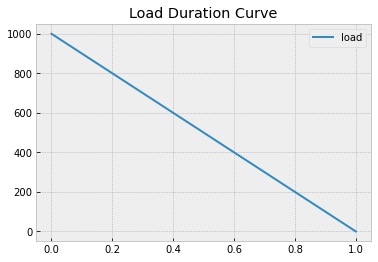

In [8]:
n.loads_t.p_set.plot(title="Load Duration Curve")

Price duration curve:

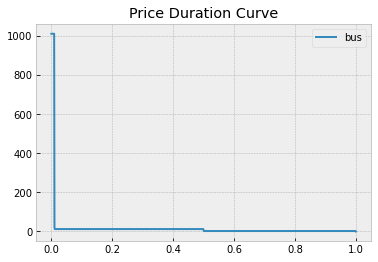

In [9]:
n.buses_t.marginal_price.plot(title="Price Duration Curve")

In [11]:
n.buses_t.marginal_price[::100]

,bus
0.0,1012.0
0.1,12.0
0.2,12.0
0.3,12.0
0.4,12.0
0.5,7.0
0.6,2.0
0.7,2.0
0.8,2.0
0.9,2.0


Generation dispatch:

Text(0, 0.5, 'MWh')

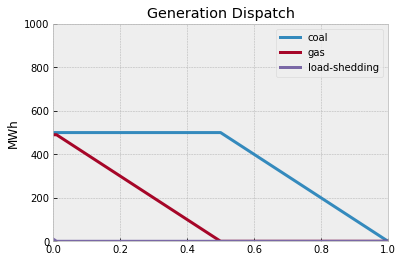

In [16]:
n.generators_t.p.plot(ylim=[0,1000],xlim=[0,1], title="Generation Dispatch", linewidth=3)
plt.ylabel("MWh")

Text(0, 0.5, 'MWh')

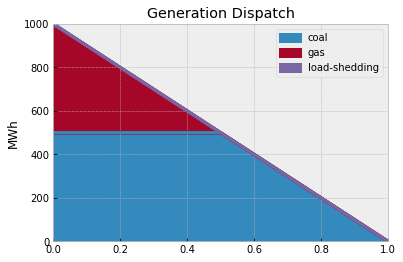

In [15]:
n.generators_t.p.plot(ylim=[0,1000],xlim=[0,1], title="Generation Dispatch", linewidth=3, kind="area", stacked=True)
plt.ylabel("MWh")

In [17]:
n.generators_t.p

,coal,gas,load-shedding
0.000,500.0,490.0,10.0
0.001,500.0,490.0,9.0
0.002,500.0,490.0,8.0
0.003,500.0,490.0,7.0
0.004,500.0,490.0,6.0
...,...,...,...
0.996,4.0,0.0,0.0
0.997,3.0,0.0,0.0
0.998,2.0,0.0,0.0
0.999,1.0,0.0,0.0


***
**(e) Demonstrate that the zero-profit condition is fulfilled.**

Calculate total costs:

In [18]:
total_costs = n.generators.p_nom_opt*n.generators.capital_cost\
    + ( n.generators_t.p.multiply(n.snapshot_weightings,axis=0).sum()\
    * n.generators.marginal_cost )
total_costs

coal             8249.750250
gas              6400.839161
load-shedding      55.604396
dtype: float64

Calculate total revenue:

In [19]:
total_revenue = n.generators_t.p\
    .multiply(n.snapshot_weightings,axis=0)\
    .multiply(n.buses_t.marginal_price["bus"],axis=0).sum()
total_revenue

coal             8249.750250
gas              6400.839161
load-shedding      55.604396
dtype: float64

In [20]:
(total_costs - total_revenue).apply(round)

coal             0
gas              0
load-shedding    0
dtype: int64